In [1]:
# SGD 적용
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns = california.feature_names)
df['target'] = california.target
# 표준 스케일링 적용
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns = california.feature_names)
df['target'] = california.target
df.tail()
scaler = StandardScaler()
df.values[:,:-1] = scaler.fit_transform(df.values[:,:-1])


In [3]:
# 학습코드
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# 데이터를 파이토치 텐서
data = torch.from_numpy(df.values).float()
x = data[:,:-1]
y = data[:,-1:]

In [4]:
class MyModel(nn.Module):
  def __init__(self,input_dim, output_dim):
    super(MyModel,self).__init__()
    self.l1 = nn.Linear(input_dim, 6)
    self.l2 = nn.Linear(6, 5)
    self.l3 = nn.Linear(5, 4)
    self.l4 = nn.Linear(4, 3)
    self.l5 = nn.Linear(3, output_dim)
    self.lkrelu = nn.LeakyReLU()
  def forward(self,x):
    x = self.lkrelu(self.l1(x))
    x = self.lkrelu(self.l2(x))
    x = self.lkrelu(self.l3(x))
    x = self.lkrelu(self.l4(x))
    x = self.l5(x)
    return x

In [8]:
model = MyModel(x.size(-1),y.size(-1))
op = optim.Adam(model.parameters(), lr = 1e-2)

batch_size = 256
for i in range(1, 100):
  # 데이터를 섞는다.
  idxs = torch.randperm(x.size(0))
  x_ = torch.index_select(x,dim=0, index=idxs)
  y_ = torch.index_select(y,dim=0, index=idxs)

  x_ = x_.split(batch_size,dim=0) # (batch_size, input_dim)
  y_ = y_.split(batch_size,dim=0) # (batch_size, output_dim)

  y_hat = []
  total_loss = 0
  
  for x_i, y_i in zip(x_,y_):    
    op.zero_grad()
    y_hat_i = model(x_i)
    loss = F.mse_loss(y_hat_i, y_i)
    loss.backward()
    op.step()
    total_loss += float(loss)  # memory leak을 방지
    y_hat += [y_hat_i]
  
  total_loss = total_loss/ len(x_)
  if i%100 == 0:
    print(f"epoch:{i}  loss:{total_loss:.4e}")



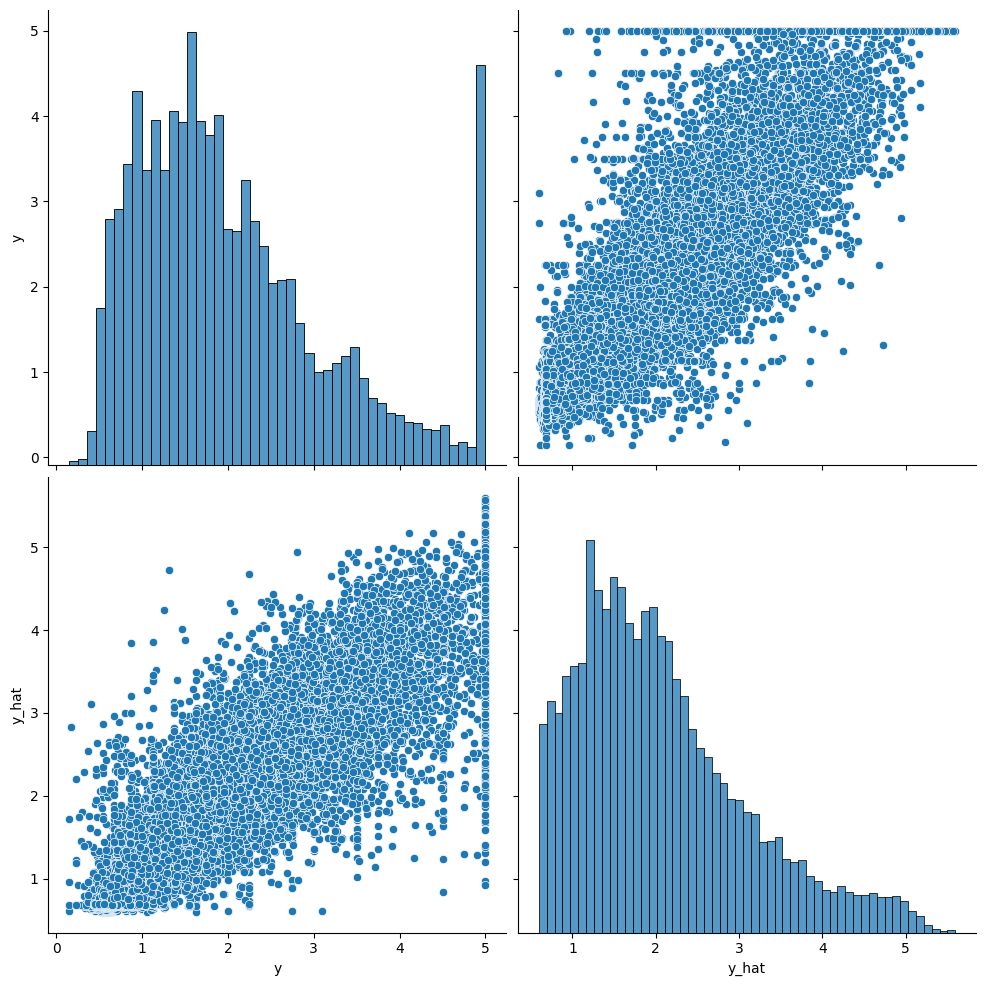

In [9]:
y_hat = torch.cat(y_hat,dim=0)      
y2 = torch.cat(y_,dim=0)
df = pd.DataFrame(torch.cat([y2,y_hat], dim=1).detach().numpy(), columns = ['y','y_hat'])
sns.pairplot(df,height=5)
plt.show()

In [35]:
# 데이터 다시 가져오기
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns = california.feature_names)
df['target'] = california.target
# 표준 스케일링 적용
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns = california.feature_names)
df['target'] = california.target

In [36]:
data = torch.from_numpy(df.values).float()
x = data[:,:-1]
y = data[:, -1:]

In [37]:
# 60 20 20
# train /valid / test 
rations = [.6, .2, .2]
train_cnt = int(data.size(0)*rations[0] )
valid_cnt = int(data.size(0)*rations[1] )
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[12384, 4128, 4128]

In [38]:
idx = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=idx)
y = torch.index_select(y, dim=0, index=idx)

In [39]:
x = list(x.split(cnts,dim=0))
y = y.split(cnts, dim=0)
for x_i, y_i in zip(x,y):
  print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [40]:
#  x[0] 학습, x[1] 검증  x[2]  테스트
# 표준스케일링 fit 시키고
# x[0] 포함해서 나머지도 정규화

In [41]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0]=torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1]=torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2]=torch.from_numpy(scaler.transform(x[2].numpy())).float()

In [43]:
# 모델 구현
class MyClass(nn.Module):
  def __init__(self,input_dim, output_dim):    # x[0].size(-1), y[0].size(-1)
    super(MyClass,self).__init__()
    self.l1 = nn.Linear(input_dim,6)
    self.l2 = nn.Linear(6,5)
    self.l3 = nn.Linear(5,4)
    self.l4 = nn.Linear(4,3)
    self.l5 = nn.Linear(3,output_dim)
    self.lrelu = nn.LeakyReLU()
  def forward(self,x):
    x = self.lrelu(self.l1(x))
    x = self.lrelu(self.l2(x))
    x = self.lrelu(self.l3(x))
    x = self.lrelu(self.l4(x))
    x = self.l5(x)
    return x

In [45]:
model = MyClass(x[0].size(-1), y[0].size(-1))
op = optim.Adam(model.parameters())
n_epochs = 1000
batch_size = 256

In [47]:
# 가장 낮은 검증손실값을 갖는 모델
# 에포크마다 학습이 끝날때 검증 데이터셋을 똑같이 피드포워딩을 해서 검증데이터셋 전체에 대한 평균 손실을 구하고
# 이젠 에포크의 검증손실값과 비교하는 작업
# if 현재 에포크 검증손실값 이전까지의 최저검증 보다 더 낮으면 최저 검증손실 값을 갱신 하고 현재 에포크 모델을 따로 저장
import numpy as np
from copy import deepcopy
lowest_loss = np.inf
best_model = None
eary_stop = 100
lowest_epoch = np.inf
train_history, valid_history = [],[]

In [ ]:
for i in range(n_epochs):
  # 학습을 위해서 데이터를 섞는다.
  indices = torch.randperm(x[0].size(0))
  x_ = torch.index_select(x[0], dim=0, index=indices)
  y_ = torch.index_select(y[0], dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0,0
  y_hat = []

  for x_i, y_i in zip(x_, y_):
    y_hat_i = model(x_i)
    loss = F.mse_loss(y_hat_i, y_i)
    op.zero_grad()
    loss.backward()
    op.step()
    train_loss += float(loss)
  train_loss = train_loss / len(x_)

  # 배치단위의 학습이 끝났으므로 이때 만들어진 모델을 가지고 
  # valid데이터에 적용해서 값을 측정
  # 이때 평가용이기 때문에.. 학습이 되면 안됨.. 즉... 가중치 업데이트 안함- 미분x 
  # 역전파가 없으므로 backward가 없음
  with torch.no_grad():
    x_ = x[1].split(batch_size,dim=0)
    y_ = y[1].split(batch_size,dim=0)
    valid_loss = 0
    for x_i, y_i in zip(x_, y_):
      y_hat_i = model(x_i)
      loss = F.mse_loss(y_hat_i, y_i)
      valid_loss += loss
      y_hat += [y_hat_i]
  valid_loss = valid_loss / len(x_)

  train_history += [train_loss]
  valid_history += [valid_loss]

  if i % 100 ==0:
    print(f"epoch:{i+1} train loss:{train_loss} valid loss:{valid_loss} lowest loss:{lowest_loss}")
  
  if valid_loss < lowest_loss:
    lowest_loss = valid_loss
    lowest_epoch = i
    best_model = deepcopy(model.state_dict())
  elif eary_stop > 0 and lowest_epoch + eary_stop < i+1:
    print("no improvement")

print(f"best validation loss from epoch {lowest_epoch+1}  loss:{lowest_loss}")